# Telco Project

## Project planning
- acquire Telco data via acquire.py file
- clean and prepare data via prepare.py file 
- define the hypothesis, set TP, TN, FP, FN
- establish baseline accuracy
- train classification models 
- choose the best performing model
- document conclusions

In [1]:
import warnings
warnings.filterwarnings("ignore")


#calculations
import numpy as np
import pandas as pd 
from scipy import stats

#dataset
from pydataset import data
import os

#sklearn stuff 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

#graphing
import matplotlib.pyplot as plt
import seaborn as sns

#acquire and prepare data
import acquire 
import prepare
import wrangle

# PLAN

# Acquire and Prepare the Data using Wrangle function

### To acquire the data, we will call from the telco_churn db

### To prepare the data we need to:
 - drop the columns that aren't necessary or that are redundant
 - fix the total charges columns to something that we can work with
 - create dummy variables to more easily deal with the the data during the machine learning portion, in general, columns that have an object dtype will need to be encoded to 1s and 0s
 - concatenate the dummy variables df to our current df
 - create a column that will bin the tenure by intervals of 5 months
 - divide the data into train, test, validate

In [2]:
# we will set wrangle to train, test, validate. 
# This function will acquire our data, prepare it, and bring it back in train, test, validate format

train, test, validate = prepare.wrangle_telco()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 4216 to 3374
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 4500 non-null   object 
 1   senior_citizen                         4500 non-null   int64  
 2   partner                                4500 non-null   object 
 3   dependents                             4500 non-null   object 
 4   tenure                                 4500 non-null   int64  
 5   phone_service                          4500 non-null   object 
 6   multiple_lines                         4500 non-null   object 
 7   online_security                        4500 non-null   object 
 8   online_backup                          4500 non-null   object 
 9   device_protection                      4500 non-null   object 
 10  tech_support                           4500 non-null   object 
 11  s

In [3]:
print(train.shape, validate.shape, test.shape)

(4500, 46) (1407, 46) (1125, 46)


In [4]:
# Stratify with churn
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn


In [5]:
X_train.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,tenure_binned
4216,Male,0,No,No,18,Yes,Yes,No,No,No,...,0,0,0,0,1,0,0,0,0,16 - 20
1477,Female,1,No,No,29,Yes,Yes,Yes,Yes,No,...,0,0,0,0,0,0,0,0,0,26 - 30
5752,Male,0,No,No,72,Yes,Yes,No internet service,No internet service,No internet service,...,1,0,0,1,0,1,0,0,0,71+
1377,Male,0,Yes,Yes,65,Yes,Yes,No,Yes,Yes,...,0,1,0,1,0,0,0,0,0,61 - 65
3965,Female,0,Yes,Yes,58,Yes,No,Yes,Yes,No,...,0,1,1,0,1,0,1,0,0,56 - 60


# Explore


In [6]:
# first, let's see how many people have churned in the train data set
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [7]:
# change this to a percentage
train.churn_Yes.mean(), validate.churn_Yes.mean(), test.churn_Yes.mean()


(0.2657777777777778, 0.2658137882018479, 0.2657777777777778)

In [30]:
churn_rate = train.churn_Yes.mean()
print('the churn rate of the train data was' , round(churn_rate,4) *100 , 'percent', '%')

the churn rate of the train data was 26.58 percent %


Takeaway: about 27% of customers are churning
 - find potential common traits of people who are churning

### Now we will look at a few different variables to see what possible traits that people who are churning could share.
- the grey line on the graphs represents the average churn rate of 27% 

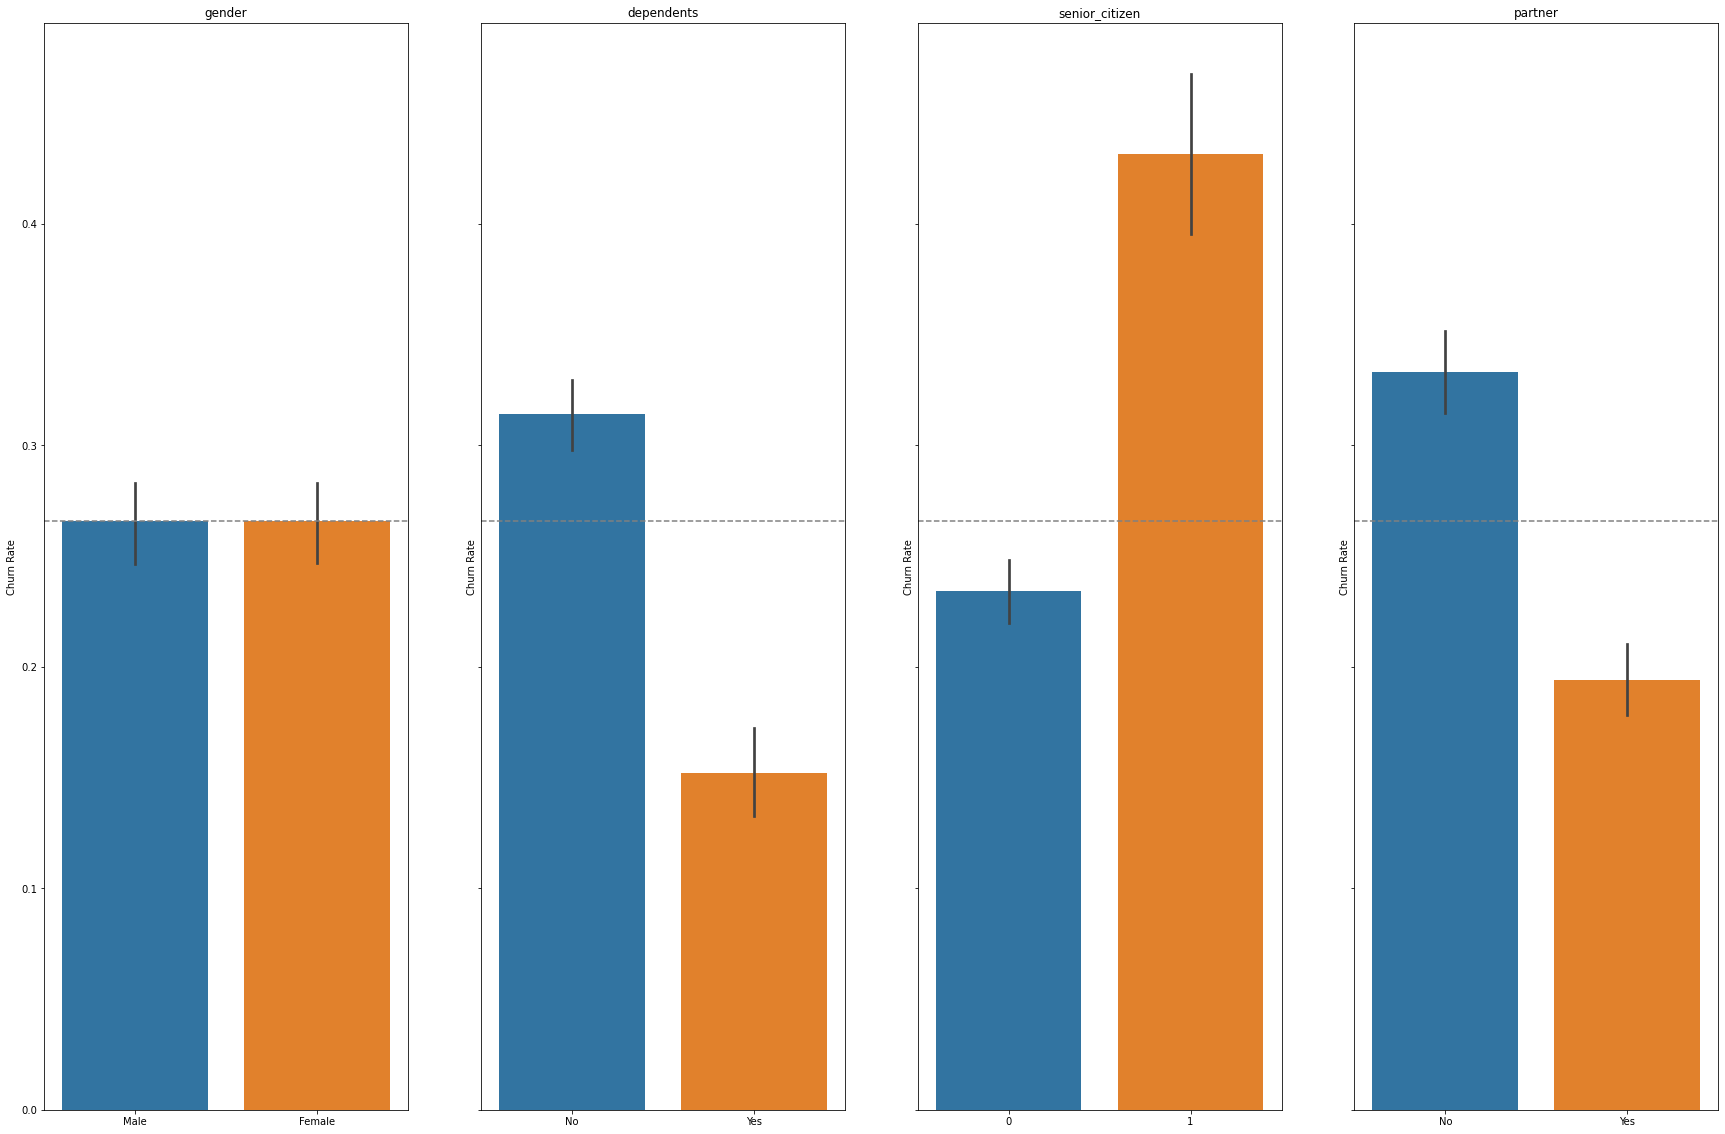

In [31]:
traits = ['gender', 'dependents', 'senior_citizen' , 'partner']
_, ax =plt.subplots(nrows = 1, ncols = 4, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

- gender doesn't appear to have an impact on churn rate
- those with dependents seem to churn less than those without dependents 
- seniors seem to churn at a much higher rate
- those without partners seem to churn higher than average

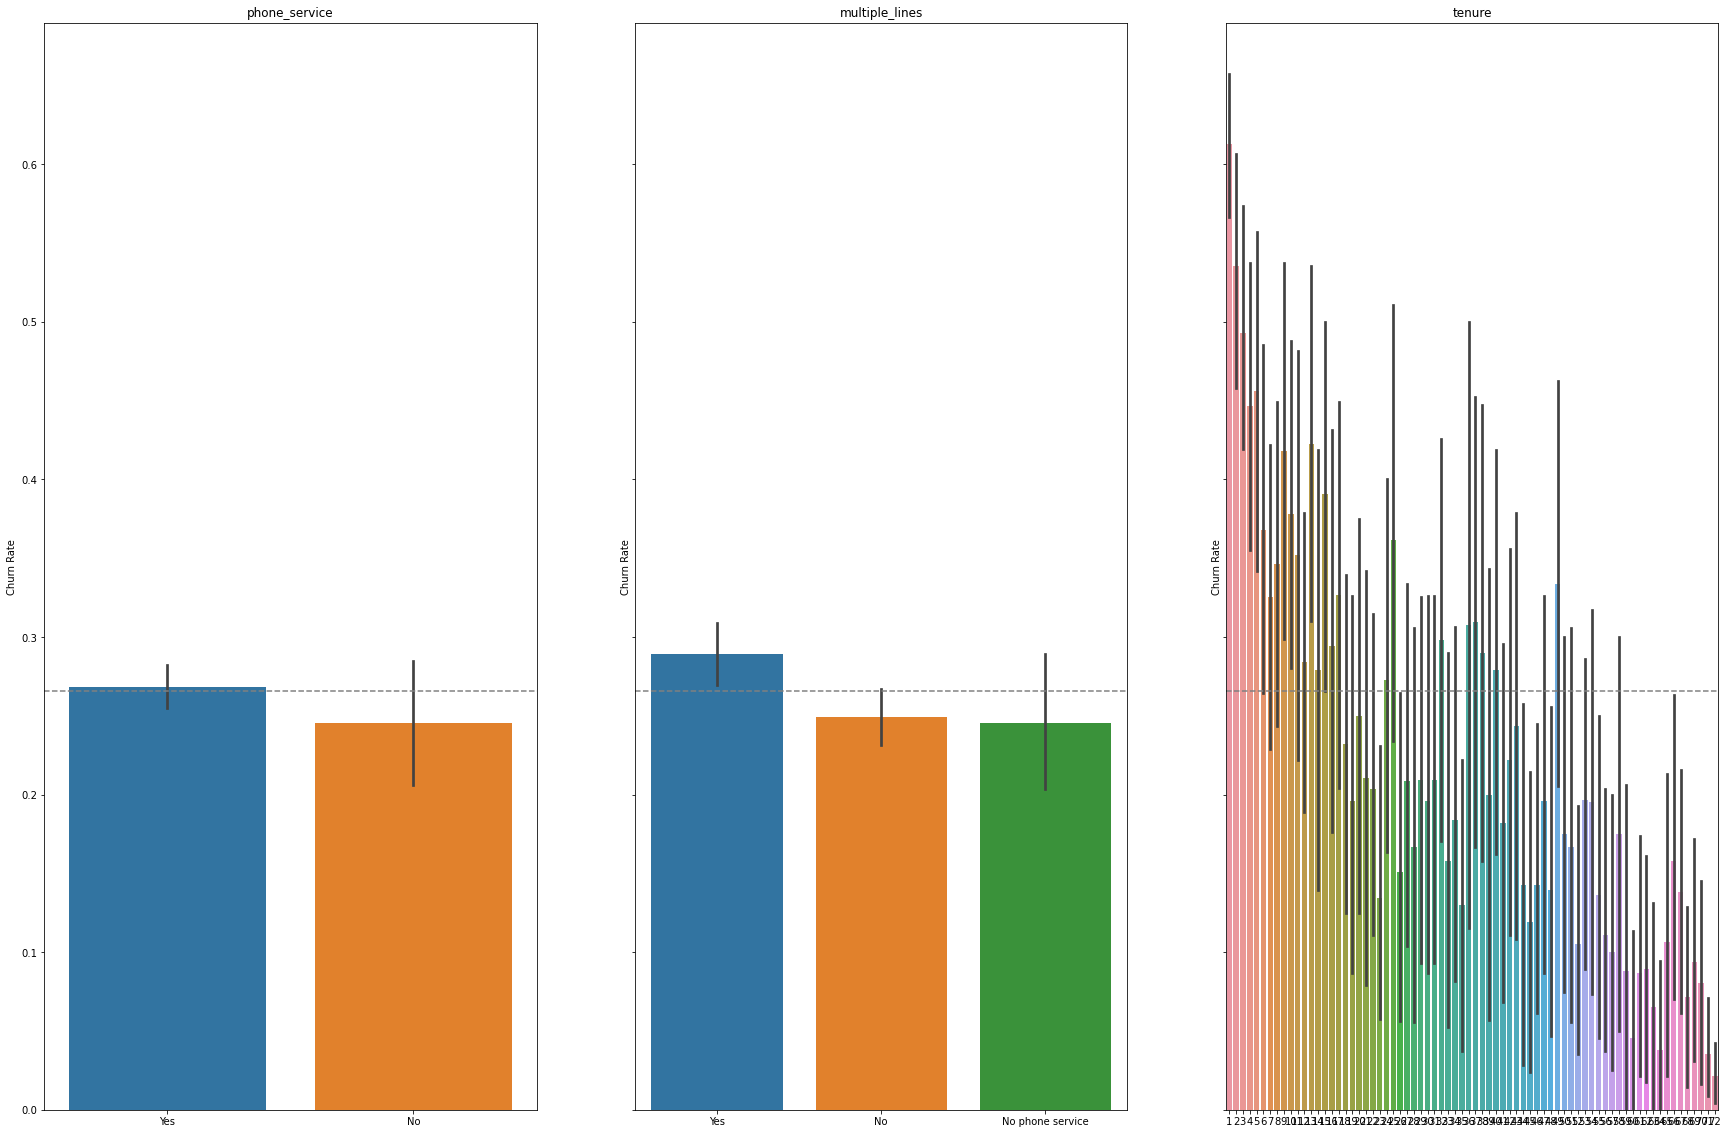

In [32]:
traits = ['phone_service', 'multiple_lines', 'tenure']
_, ax =plt.subplots(nrows = 1, ncols = 3, figsize = (30,20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'grey')

- phone service or whether or not a person has multiple lines doesn't seem to have much of an impact
- Bin tenure in intervals of 5 months to try to get a easier to understand graph 

## Taking a deeper look at Churn as it relates to Tenure

In [33]:
# have to create an order list so the graph columns appear in the correct order
order_list = ['1 - 5',
               '6 - 10',
 '11 - 15',
 '16 - 20',
 '21 - 25',
 '26 - 30',
 '31 - 35',
 '36 - 40',
 '41 - 45',
 '46 - 50',
 '51 - 55',
 '56 - 60',
 '61 - 65',
 '66 - 70',
 '71+']

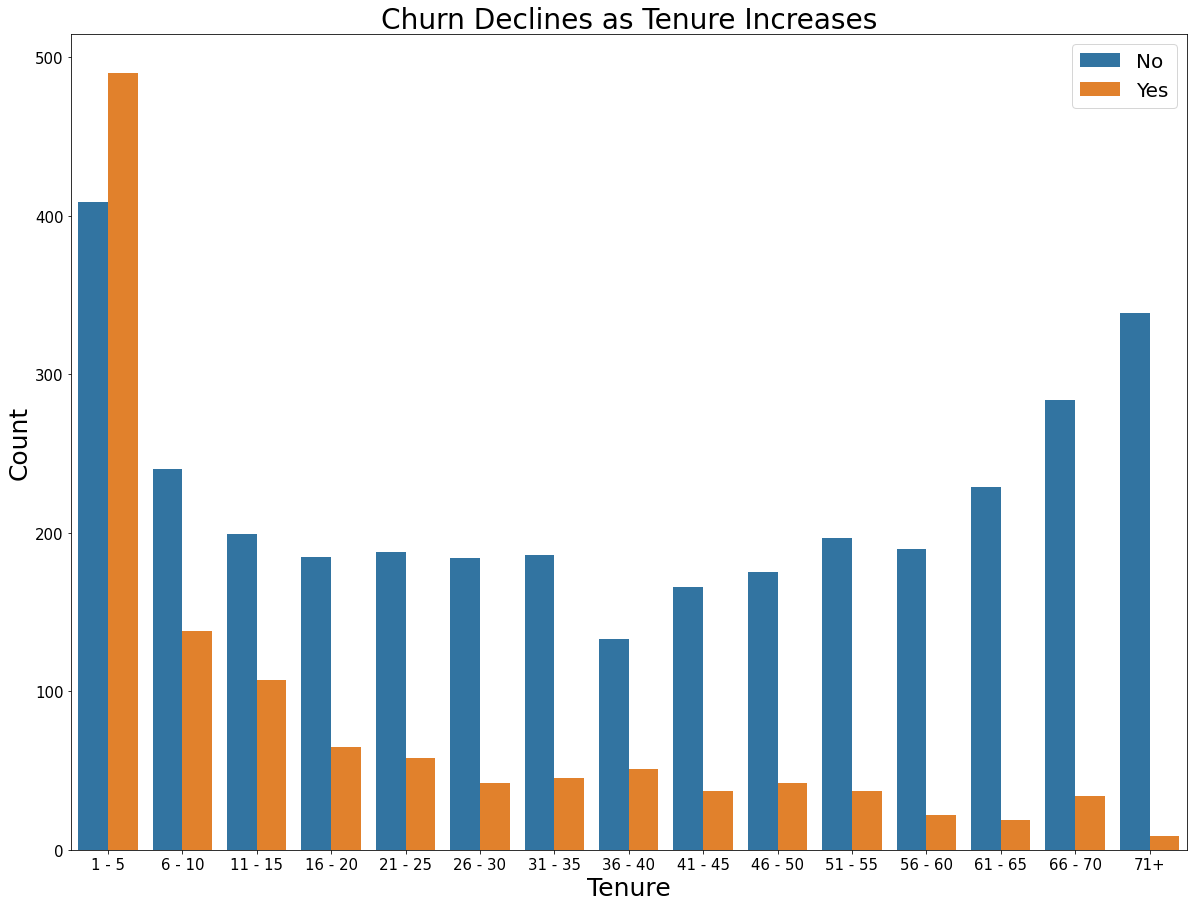

In [34]:
plt.figure(figsize = (20,15))
ax=sns.countplot(x = "tenure_binned", hue = "churn", data = train , order = order_list)
ax.set_title("Churn Declines as Tenure Increases", fontsize = 28)
plt.xlabel("Tenure",fontsize=25)
plt.ylabel("Count", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(loc="upper right", frameon=True, fontsize=20)

This gives us a count of people that have left by month, but getting a percentage of customers who churn by month would paint a more accurate picture

In [35]:
tb_perc = train.groupby(['tenure_binned'])
tb_perc = round(tb_perc.mean().churn_Yes*100,2)
tb_perc

tenure_binned
1 - 5      54.51
11 - 15    34.97
16 - 20    26.00
21 - 25    23.58
26 - 30    18.58
31 - 35    19.48
36 - 40    27.72
41 - 45    18.23
46 - 50    19.35
51 - 55    15.81
56 - 60    10.38
6 - 10     36.51
61 - 65     7.66
66 - 70    10.69
71+         2.59
Name: churn_Yes, dtype: float64

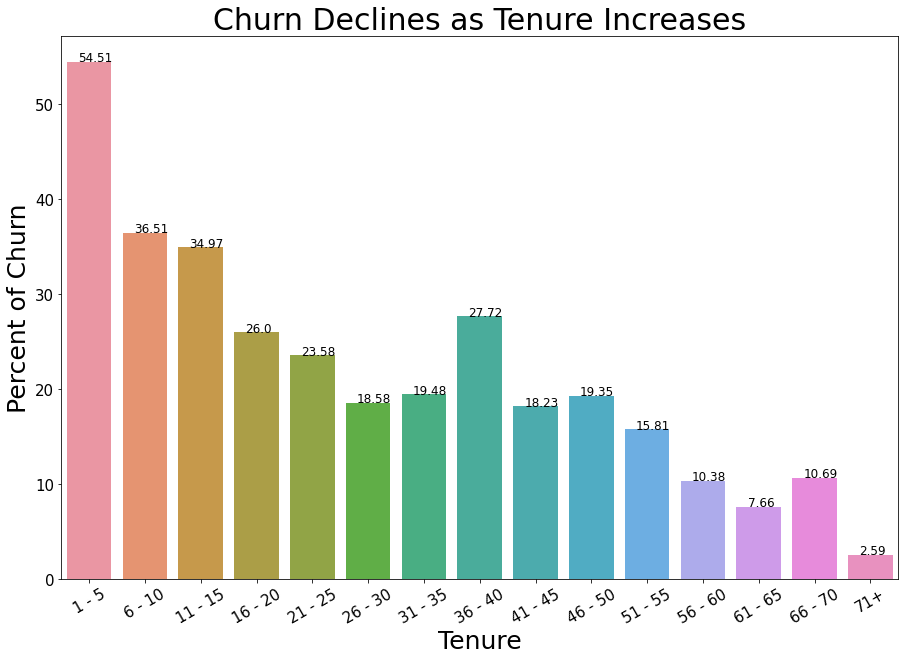

In [36]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= tb_perc , x = tb_perc.index, order = order_list)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn Declines as Tenure Increases", fontsize = 30)
plt.xlabel("Tenure",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=12, ha="left")

Takeaways:
 - percentage of churn decreases as tenure increases
 - get customers past the first 5 months and rate of churn decreases by nearly 20%
 - my months 16-20, rate of churn is nearly half of what it was in the first 5 months 

## Churn as it relates to internet service types

In [15]:
# percentage of churn by internet service types
internet_perc = train.groupby(['internet_service_type'])
internet_perc = round(internet_perc.mean().churn_Yes*100,2)
internet_perc

internet_service_type
DSL            18.57
Fiber optic    42.44
None            7.39
Name: churn_Yes, dtype: float64

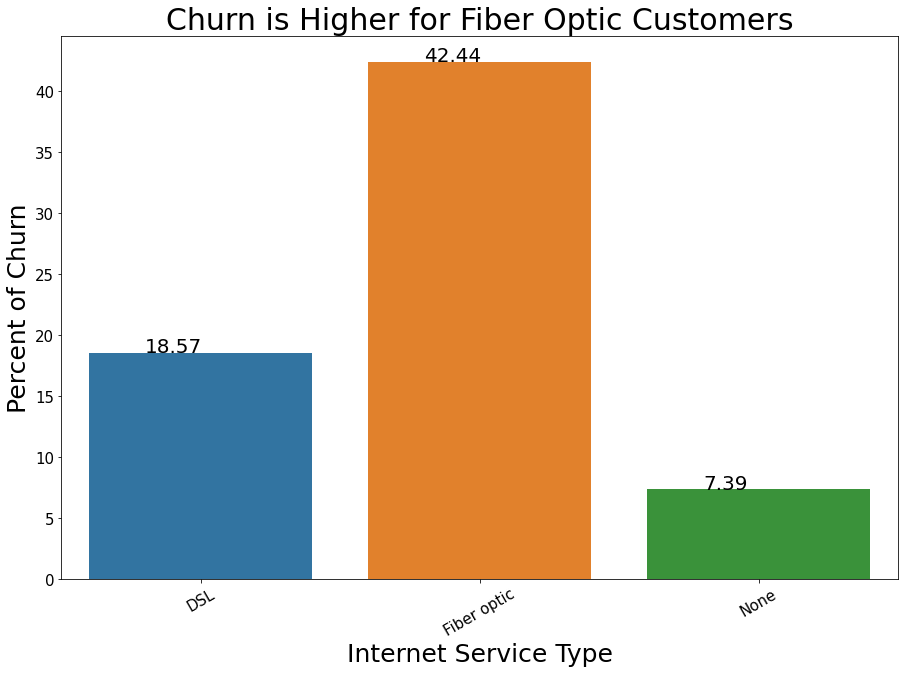

In [16]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= internet_perc , x = internet_perc.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn is Higher for Fiber Optic Customers", fontsize = 30)
plt.xlabel("Internet Service Type",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=20, ha="left")

Takeaways:
- Customers with Fiber optic internet are over twice as likely to churn as those that have DSL 
- offer temporary discounts for fiber optic customers when they are attempting to leave 

## Churn as it relates to Payment Types

In [17]:
# percentage of churn by payment types
payment_perc = train.groupby(['payment_type'])
payment_perc = round(payment_perc.mean().churn_Yes*100,2)
payment_perc

payment_type
Bank transfer (automatic)    17.01
Credit card (automatic)      16.28
Electronic check             44.98
Mailed check                 18.94
Name: churn_Yes, dtype: float64

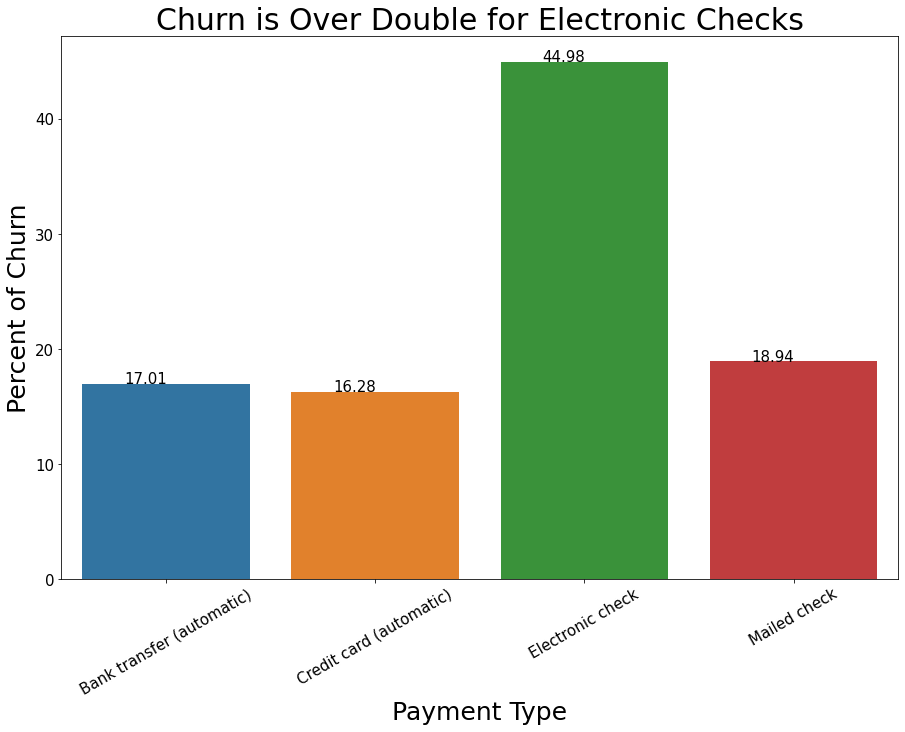

In [18]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= payment_perc , x = payment_perc.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn is Over Double for Electronic Checks", fontsize = 30)
plt.xlabel("Payment Type",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=15, ha="left")

- Customers that pay by Electronic Check are drastically more likely to churn. 
- Advertise other methods of payments more than electronic checks, but we want to keep the option for electronic checks 


## Senior Citizens and Churn

In [19]:
senior_perc = train.groupby(['senior_citizen'])
senior_perc = round(senior_perc.mean().churn_Yes*100,2)
senior_perc

senior_citizen
0    23.40
1    43.15
Name: churn_Yes, dtype: float64

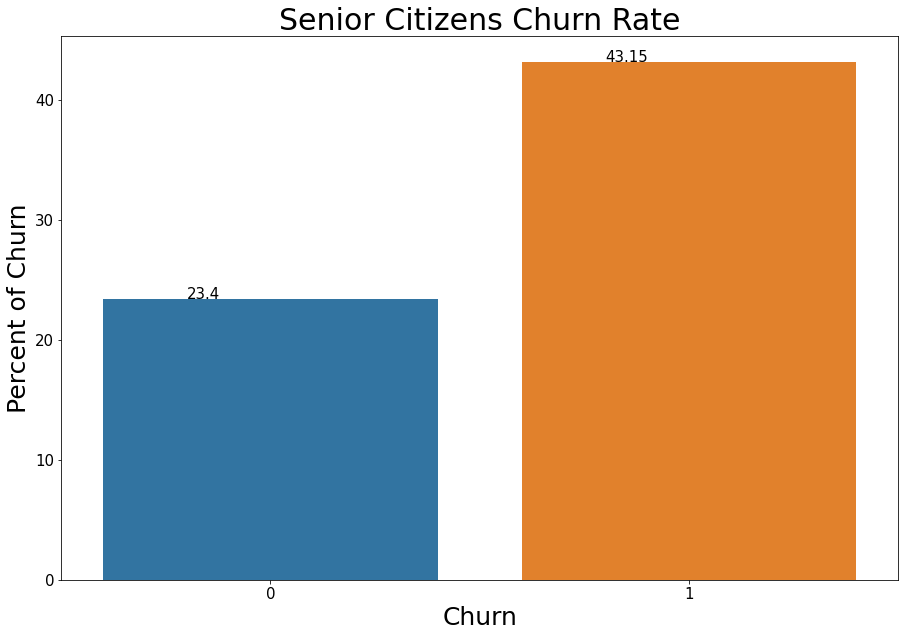

In [20]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= senior_perc , x = senior_perc.index)
ax.set_xticklabels(ax.get_xticklabels())
ax.set_title("Senior Citizens Churn Rate", fontsize = 30)
plt.xlabel("Churn",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=15, ha="left")

- 0 represents customers that aren't senior citizens. Here it is about a 23% churn rate.
- 1 represents customers that are senior citizens. These customers have a 43% churn rate. 
- Senior Citizens churn at a very high rate. This could be caused by seniors either forgetting to pay their bills, moving in with family members/ into retirement homes, or passing away
- This is unfortunately a group that could be harder to retain. 

# Modeling

In [21]:
# for modeling, we are going to make a second df that gets rid of columns that are objects 


In [22]:
df2 = train.select_dtypes(exclude=['object']) 
df2.shape()

TypeError: 'tuple' object is not callable